# Symbolic regression

Here we perform UQ for the policy of a GFlowNet trained on a symbolic regression problem using PCE.

Import neccessary libraries.

In [18]:
from matplotlib import pyplot as plt
from torch.distributions import Normal, Categorical
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import torch
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.distributions.categorical import Categorical
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import colormaps as cm
import tqdm
import torch.optim as optim
from collections import Counter
import networkx as nx
from collections import deque
from tqdm import tqdm
import pandas as pd
import random
from matplotlib.colors import LogNorm
if not hasattr(np, 'bool'):
    np.bool = bool
import chaospy as chaos
import operator
import sympy
import symb_reg_helpers as h
import importlib
from sklearn import linear_model as lm
from scipy.special import softmax
sns.set(font='Times New Roman', style = 'white')

We begin by evaluating the ground truth function that we want to regress on a grid of equispaced points, and add noise using a Wiener process.

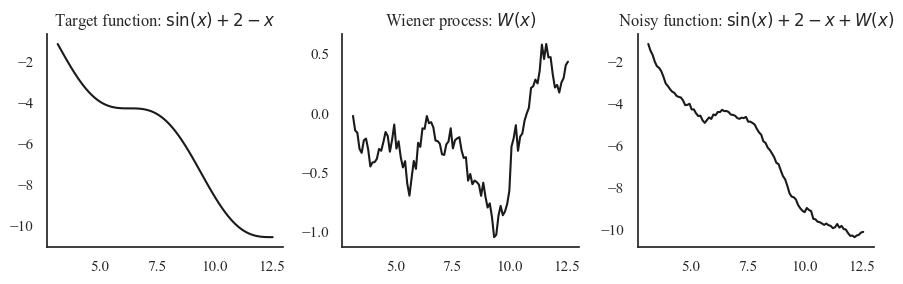

In [ ]:
target_function = lambda x: np.sin(x) + 2 - x
x_points = np.linspace(np.pi, 4*np.pi, 100)

dt = 0.01
wiener = np.cumsum(np.random.normal(0,np.sqrt(dt),100))

fig, ax = plt.subplots(1,3)
fig.set_size_inches(9,3)

ax[0].plot(x_points,target_function(x_points), color='k')
ax[1].plot(x_points,wiener, color='k')

y_target = target_function(x_points) + wiener

ax[2].plot(x_points,y_target, color='k')

ax[0].set_title(r'Target function: $\sin(x)+2-x$')
ax[1].set_title(r'Wiener process: $W(x)$')
ax[2].set_title(r'Noisy function: $\sin(x)+2-x + W(x)$')

sns.despine()
plt.tight_layout()
plt.show()

To embed each of these noisy functions in a low-dimensional space, we perform the Karhunen-Loeve expansion and use the first two coefficients as the low-dimensional representation. They are normal distributed with mean-zero.

We can calculate the exact KL expansion coefficients for a Wiener process.

In [3]:
def phi(n, t, T):
    return np.sqrt(2 / T) * np.sin((n - 0.5) * np.pi * t / T)

def lambda_n(n, T):
    return T**2 / ((n - 0.5)**2 * np.pi**2)

We import the pretrained ensemble of GFNs that solves the symbolic regression problem.

In [4]:
N = 250

model_ensemble = []
env_ensemble = []

Z = np.zeros((N,100))

target_function = lambda x: np.sin(x) + 2 - x
x_points = np.linspace(np.pi, 4*np.pi, 100)


for n in range(N):

    Z_ = np.array(pd.read_csv('training_ensemble/Z_sobol_' + str(n+1) + '.csv',header=None,dtype=float,sep=' ')).reshape(100)
    Z[n,:] = Z_

    W = h.wiener_reconstruct(Z_)
    y_target = target_function(x_points) + W
    
    env = h.SymbolicRegressionEnv(y_target, x_points)
    env_ensemble.append(env)

    model = h.GFlowNetModel(vocab_size=env.action_space_size)

    state_dict = torch.load('training_ensemble/symb_gfn_1_sobol_' + str(n+1) + '.pth')
    model.load_state_dict(state_dict)
    model.eval()
    model_ensemble.append(model)

We then pick a trajectory, in this case one of the exact solutions, and extract the policy from these models along this trajectory.

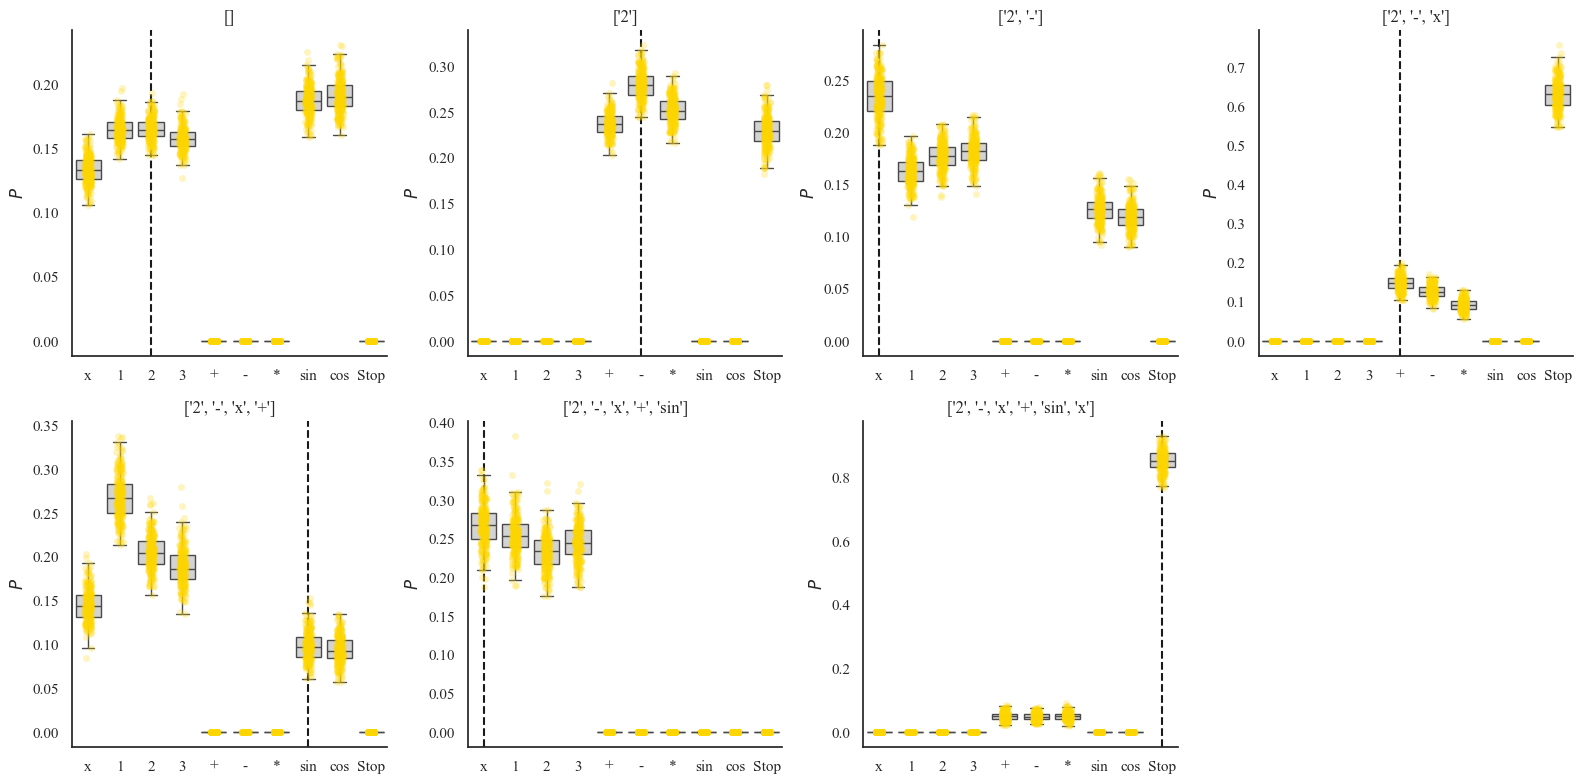

In [10]:
env = h.SymbolicRegressionEnv(y_target, x_points)
traj = '2 - x + sin x'
tokens = traj.split(' ')
all_tokens = env.tokens

tokens.append('Stop')
all_tokens.append('Stop')

policy_values = np.zeros((N,len(tokens),len(all_tokens)))

for n, model in enumerate(model_ensemble):
    
    env = env_ensemble[n]

    policy = np.array(h.policy_along_trajectory(tokens,model,env))

    if policy.shape[1] == len(all_tokens):
        policy_values[n,:,:] = policy
    else:
        policy_values[n,:,:len(all_tokens)-1] = policy

fig, ax = plt.subplots(2,4)
fig.set_size_inches(16,8)

for j in range(0,len(tokens)):
    
    k = int(np.mod(j,4))
    l = int(np.floor(j/4))

    sns.stripplot(policy_values[:,j,:], ax = ax[l,k], color = 'gold', alpha = 0.25)
    sns.boxplot(policy_values[:,j,:], ax = ax[l,k], color = 'lightgrey',showfliers=False)

    ax[l,k].set_xticks(range(10))
    ax[l,k].set_xticklabels(all_tokens)
    ax[l,k].axvline(env.tokens.index(tokens[j]), color ='k', linestyle = 'dashed')
    ax[l,k].set_title(str(tokens[:j]))
    ax[l,k].set_ylabel(r'$P$')
    sns.despine()

ax[1,3].axis('off')
plt.tight_layout()
plt.show()

We apply the logit-transform to project policy values onto the real-line.

In [11]:
Z_1 = Z[:,0]
Z_2 = Z[:,1]

reward_input = Z[:,:2]

def logit(y):
    return np.log(y/(1-y))

def sigmoid(x):
    return 1/(1+np.exp(-x))

epsilon = 1e-10
A_safe = np.where(policy_values == 0, epsilon, policy_values)
logit_ensemble_policy = logit(A_safe)

Given that we have a Gaussian distribution, we can construct an orthonormal polynomial basis using Hermite polynomials.

In [12]:
degree = 14

q0, q1 = chaos.numpoly.variable(2)

hermite_1 = chaos.expansion.hermite(degree, mu=0, sigma=1,normed=False)
hermite_2 = chaos.expansion.hermite(degree, mu=0, sigma=1,normed=False)

hermite1 = hermite_1(q0)
hermite2 = hermite_2(q1)

outer_product_basis = chaos.outer(hermite1, hermite2).flatten()
polynomial_basis = outer_product_basis[np.sum(outer_product_basis.exponents, axis=1) <= degree]

lstsquares = lm.LinearRegression(fit_intercept= False)
ridge = lm.Ridge(alpha=0.1,fit_intercept= False)

We then fit the coefficients with Ridge regression.

In [13]:
ridge_model_list = []

all_zeros = []

for i in range(logit_ensemble_policy.shape[1]):
    
    ridge_models = []

    for j in range(logit_ensemble_policy.shape[2]):
        if np.all(policy_values[:,i,j]==0):
            all_zeros.append((i,j))

        r_fitted_polynomial = chaos.fit_regression(polynomial_basis, reward_input.T, logit_ensemble_policy[:,i,j], model=ridge)
        ridge_models.append(r_fitted_polynomial)
    
    ridge_model_list.append(ridge_models)

To evaluate outputs from this surrogate model, we take new samples from the low-dimensional distribution to use an inputs into the PCE. We then use the softmax to turn these outputs back into probability distributions.

In [14]:
dist_list = [chaos.Normal(0,1), chaos.Normal(0,1)]
joint_dist = chaos.J(*dist_list)

N_samples = 10000

surrogate_inputs = joint_dist.sample(N_samples)

ridge_outputs = np.zeros((7,10,N_samples))
softmax_ridge_outputs = np.zeros((7,10,N_samples))

for i in range(0,7):
    for j in range(0,10):
        ridge_outputs[i,j,:] = ridge_model_list[i][j](*surrogate_inputs)
        if (i,j) in all_zeros:
            ridge_outputs[i,j,:] = -np.inf
    softmax_ridge_outputs[i,:,:] = softmax(ridge_outputs[i,:,:],axis = 0)

ridge_outputs = sigmoid(ridge_outputs)

ridge_outputs_n = ridge_outputs / ridge_outputs.sum(axis=1, keepdims=True)

/var/folders/yy/6rdr8gsx4w381cbvbfngv_nc0000gn/T/ipykernel_99180/3784909625.py:10: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


We want to compare our surrogate inputs to empirical inputs from a testing ensemble of models which were not used to fit the surrogate model.

In [15]:
N = 250

test_model_ensemble = []
test_env_ensemble = []

Z = np.zeros((N,100))

target_function = lambda x: np.sin(x) + 2 - x
x_points = np.linspace(np.pi, 4*np.pi, 100)


for n in range(N):

    Z_ = np.array(pd.read_csv('testing_ensemble/Z_' + str(n+1) + '.csv',header=None,dtype=float,sep=' ')).reshape(100)
    Z[n,:] = Z_

    W = h.wiener_reconstruct(Z_)
    y_target = target_function(x_points) + W
    
    env = h.SymbolicRegressionEnv(y_target, x_points)
    test_env_ensemble.append(env)

    model = h.GFlowNetModel(vocab_size=env.action_space_size)

    state_dict = torch.load('testing_ensemble/symb_gfn_1_' + str(n+1) + '.pth')
    model.load_state_dict(state_dict)
    model.eval()
    test_model_ensemble.append(model)

In [16]:
test_policy_values = np.zeros((N,len(tokens),len(all_tokens)))

for n, model in enumerate(test_model_ensemble):
    
    env = test_env_ensemble[n]

    policy = np.array(h.policy_along_trajectory(tokens,model,env))

    if policy.shape[1] == len(all_tokens):
        test_policy_values[n,:,:] = policy
    else:
        test_policy_values[n,:,:len(all_tokens)-1] = policy

We can then plot these testing policies against surrogate policies.

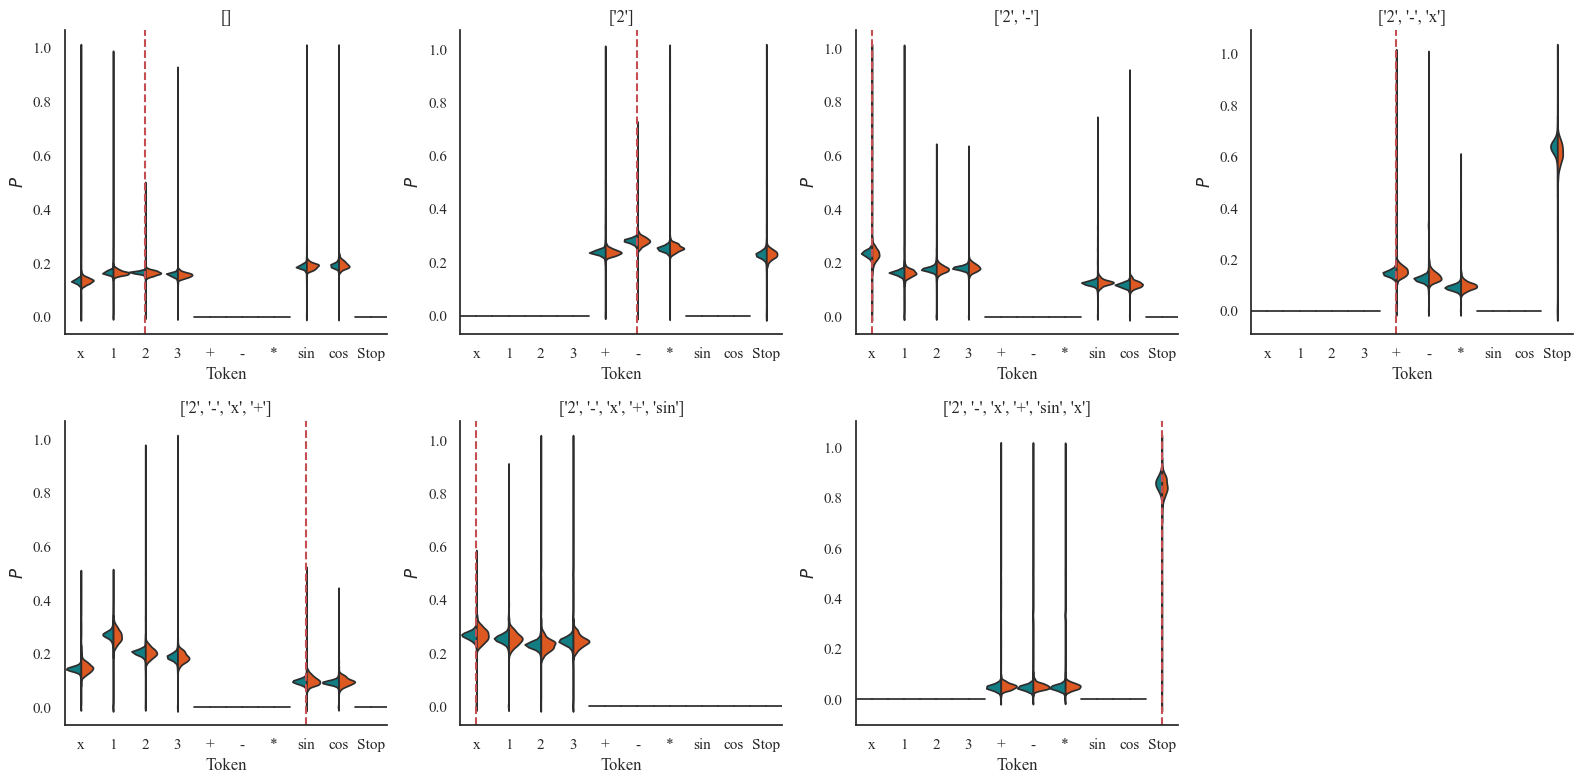

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
cols = ['#008E97','#FC4C02']

for j in range(len(tokens)):
    k = int(np.mod(j, 4))
    l = int(np.floor(j / 4))

    df_policy = pd.DataFrame(test_policy_values[:, j, :])
    df_policy = df_policy.melt(var_name="token_idx", value_name="value")
    df_policy["source"] = "policy"

    df_softmax = pd.DataFrame(ridge_outputs_n[j, :, :].T)
    df_softmax = df_softmax.melt(var_name="token_idx", value_name="value")
    df_softmax["source"] = "softmax"


    df_plot = pd.concat([df_softmax, df_policy], ignore_index=True)

    sns.violinplot(
        data=df_plot,
        x="token_idx", y="value", hue="source",
        ax=ax[l, k], split=True, palette=cols,  inner=None,legend=False, width = 1
    )

    ax[l, k].set_xticks(range(10))
    ax[l, k].set_xticklabels(all_tokens)
    ax[l, k].axvline(all_tokens.index(tokens[j]), color='r', linestyle='dashed')
    ax[l, k].set_title(str(tokens[:j]))
    sns.despine(ax=ax[l, k])
    ax[l,k].set_xlabel('Token')
    ax[l,k].set_ylabel(r'$P$')

ax[1, 3].axis('off')
plt.tight_layout()
plt.show()

## Comparison with a multilayer perceptron

We now fit a surrogate model based on a MLP to compare to the PCE

In [19]:
class MLPPolicy(nn.Module):
    def __init__(self, hidden_sizes=[64, 64], num_actions=10):
        super().__init__()
        layers = []
        input_dim = 2
        for h in hidden_sizes:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        layers.append(nn.Linear(input_dim, num_actions))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.net(x)
        return logits

In [20]:
models = []

for i in range(0,7):
    print(i)
    dataset = torch.utils.data.TensorDataset(
    torch.tensor(reward_input, dtype=torch.float32),
    torch.tensor(policy_values[:, i, :], dtype=torch.float32)
)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

    model = MLPPolicy()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(100):
        for xb, yb in dataloader:
            # Step 1: Get the predicted logits from the model
            pred_logits = model(xb)
            
            log_probs = F.log_softmax(pred_logits, dim=-1)
                        
            loss = F.kl_div(log_probs, yb, reduction="batchmean")
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"epoch {epoch}, loss = {loss.item():.4f}")
    
    models.append(model)

0
epoch 0, loss = 0.3883
epoch 1, loss = 0.2727
epoch 2, loss = 0.1717
epoch 3, loss = 0.1009
epoch 4, loss = 0.0488
epoch 5, loss = 0.0264
epoch 6, loss = 0.0218
epoch 7, loss = 0.0148
epoch 8, loss = 0.0102
epoch 9, loss = 0.0086
epoch 10, loss = 0.0063
epoch 11, loss = 0.0072
epoch 12, loss = 0.0057
epoch 13, loss = 0.0047
epoch 14, loss = 0.0046
epoch 15, loss = 0.0047
epoch 16, loss = 0.0053
epoch 17, loss = 0.0036
epoch 18, loss = 0.0046
epoch 19, loss = 0.0040
epoch 20, loss = 0.0037
epoch 21, loss = 0.0035
epoch 22, loss = 0.0028
epoch 23, loss = 0.0029
epoch 24, loss = 0.0027
epoch 25, loss = 0.0025
epoch 26, loss = 0.0025
epoch 27, loss = 0.0031
epoch 28, loss = 0.0028
epoch 29, loss = 0.0029
epoch 30, loss = 0.0025
epoch 31, loss = 0.0028
epoch 32, loss = 0.0027
epoch 33, loss = 0.0026
epoch 34, loss = 0.0035
epoch 35, loss = 0.0026
epoch 36, loss = 0.0023
epoch 37, loss = 0.0028
epoch 38, loss = 0.0025
epoch 39, loss = 0.0029
epoch 40, loss = 0.0024
epoch 41, loss = 0.0026


We then run our MLP surrogate models on the inputs from earlier.

In [23]:
outputs = np.zeros((surrogate_inputs.shape[1], 7, 10), dtype=np.float32)

for i in range(0,7):
    model = models[i]
    with torch.no_grad():
        preds = model(torch.tensor(surrogate_inputs.T, dtype=torch.float32))
    outputs[:, i, :] = preds.numpy()

outputs_tensor = torch.from_numpy(outputs)
mlp_ouputs = F.softmax(outputs_tensor, dim=-1).numpy()

env.tokens.append('Stop')

We then plot the surrogate and testing outputs against each other.

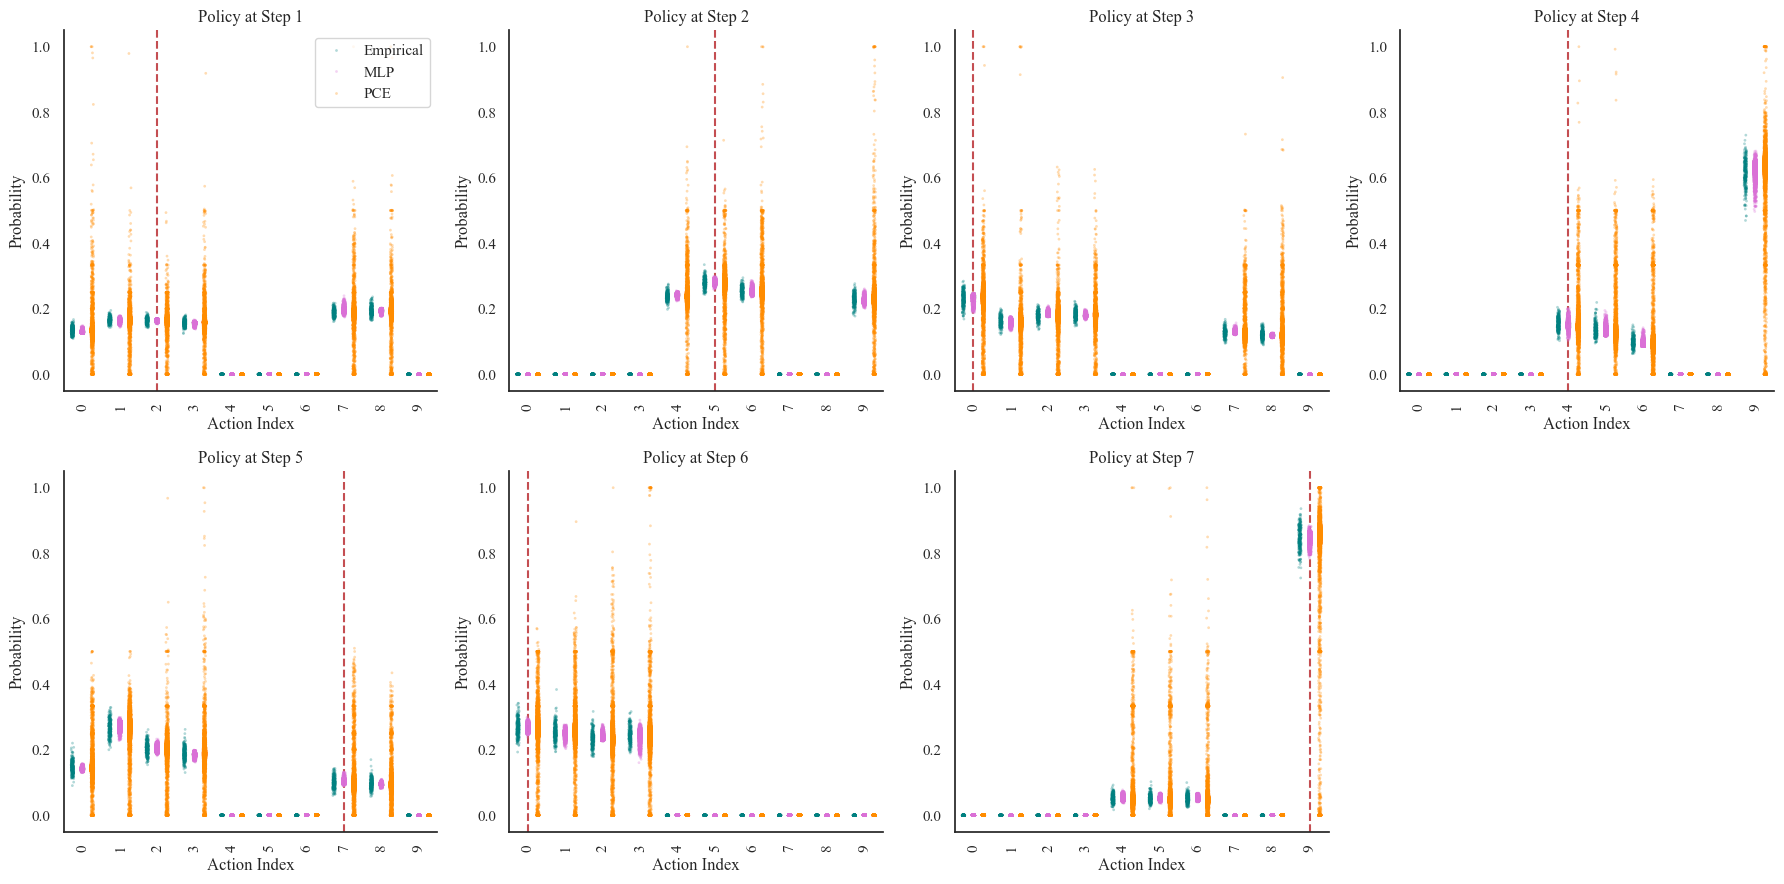

In [24]:
cols = ['#008E97', '#FC4C02']
fig, ax = plt.subplots(2, 4, figsize=(18, 9))

# make first panel empty
ax[1, 3].axis("off")

# loop over 7 steps → map to axes 1..7 (skip ax[0,0])
for n in range(7):
    # axis index (skip the first panel)
    idx = n
    i = idx // 4
    j = idx % 4

    # empirical + surrogate data
    data_n = test_policy_values[:, n, :]
    mlp_n = mlp_ouputs[:, n, :]
    surrogate_n = ridge_outputs_n[n, :, :].T

    # reshape into long form DataFrame
    df_emp = pd.DataFrame(data_n).melt(var_name="Action", value_name="Probability")
    df_emp["Source"] = "Empirical"

    df_mlp = pd.DataFrame(mlp_n).melt(var_name="Action", value_name="Probability")
    df_mlp["Source"] = "MLP"

    df_sur = pd.DataFrame(surrogate_n).melt(var_name="Action", value_name="Probability")
    df_sur["Source"] = "PCE"

    df_all = pd.concat([df_emp, df_mlp, df_sur], ignore_index=True)

    # plot stripplot (side-by-side strips)
    sns.stripplot(
        data=df_all, x="Action", y="Probability", hue="Source",
        dodge=True, jitter=True, alpha=0.3,
        palette={"Empirical": "teal", "MLP": "orchid", "PCE": "darkorange"},
        ax=ax[i, j],
        rasterized=True,
        s = 2
    )

    ax[i, j].tick_params(axis="x", rotation=90)
    ax[i, j].set_title(f"Policy at Step {n+1}")
    ax[i, j].set_xlabel("Action Index")
    ax[i, j].set_ylabel("Probability")
    ax[i, j].axvline(env.tokens.index(tokens[n]), color='r', linestyle='dashed')


    # legend handling
    if n == 0:  # only for the 2nd panel overall
        ax[i, j].legend(loc="upper right")
    else:
        ax[i, j].get_legend().remove()

sns.despine()
plt.tight_layout()
plt.show()